In [ ]:
%load_ext autoreload
%autoreload 2

In [63]:
import pandas as pd
import numpy as np
from util import create_dataset,create_prompt,create_prompt_df,text_embedding,behavior_embedding
import matplotlib.pyplot as plt

In [ ]:
power = range(2,10,1)
gain_S = range(1,20,3)
gain_O = range(1,20,3)
cost = range(1,20,3)

In [ ]:
data = create_dataset(power, gain_S, gain_O, cost)

In [ ]:
prompt_df = create_prompt_df(data)

In [ ]:
prompt_df_test = prompt_df.iloc[1:20]

In [47]:
text_embedding_results = text_embedding(20,prompt_df)

100%|██████████| 10976/10976 [08:46<00:00, 20.84it/s]


In [49]:
text_embedding_results = np.array(text_embedding_results,dtype = 'float32')

In [50]:
np.save('text_embedding.npy',text_embedding_results)

In [51]:
text_embedding_results = np.load('text_embedding.npy')

In [52]:
behavior_embedding_results = behavior_embedding(data)

In [53]:
print(type(text_embedding_results[0,1]))

<class 'numpy.float32'>


In [54]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

##2. construct dataloader, model for training
class JointDataset(Dataset):
    def __init__(self, text_embeddings, decision_embeddings, labels):
        self.text_embeddings = text_embeddings
        self.decision_embeddings = decision_embeddings
        self.labels = labels

        # Ensure both embeddings have the same number of samples
        assert self._get_num_samples(self.text_embeddings) == self._get_num_samples(self.decision_embeddings), "Mismatched number of samples between text and decision embeddings."

    def __len__(self):
        return self._get_num_samples(self.text_embeddings)

    def __getitem__(self, idx):
        return {
            "text_embedding": self.text_embeddings[idx],
            "decision_embedding": self.decision_embeddings[idx],
            "label": self.labels[idx]
        }

    def _get_num_samples(self, data):
        if isinstance(data, (list, tuple)):
            return len(data)
        elif isinstance(data, (np.ndarray, torch.Tensor)):
            return data.shape[0]
        else:
            raise TypeError("Unsupported type for embeddings")
            
def generate_labels(embeddings_1, embeddings_2, false_scale=1):
    # True labels
    true_labels = np.ones(embeddings_1.shape[0])
    
    # Initialize lists to hold the combined embeddings and labels
    combined_embeddings_1 = list(embeddings_1)
    combined_embeddings_2 = list(embeddings_2)
    combined_labels = list(true_labels)
    
    for _ in range(false_scale):
        # Shuffling embeddings_2 for false labels
        shuffled_embeddings_2 = np.random.permutation(embeddings_2)
        
        # Append false data and labels
        combined_embeddings_1.extend(embeddings_1)
        combined_embeddings_2.extend(shuffled_embeddings_2)
        combined_labels.extend(np.zeros(embeddings_1.shape[0]))  # false_labels
        
    # Convert lists back to numpy arrays
    combined_embeddings_1 = np.array(combined_embeddings_1)
    combined_embeddings_2 = np.array(combined_embeddings_2)
    combined_labels = np.array(combined_labels)
    
    return combined_embeddings_1, combined_embeddings_2, combined_labels  

class Dataset(Dataset):
    def __init__(self, text_embeddings, decision_embeddings):
        self.text_embeddings = text_embeddings
        self.decision_embeddings = decision_embeddings

        # Ensure both embeddings have the same number of samples
        assert self._get_num_samples(self.text_embeddings) == self._get_num_samples(self.decision_embeddings), "Mismatched number of samples between text and decision embeddings."

    def __len__(self):
        return self._get_num_samples(self.text_embeddings)

    def __getitem__(self, idx):
        return {
            "text_embedding": self.text_embeddings[idx],
            "decision_embedding": self.decision_embeddings[idx],
        }

    def _get_num_samples(self, data):
        if isinstance(data, (list, tuple)):
            return len(data)
        elif isinstance(data, (np.ndarray, torch.Tensor)):
            return data.shape[0]
        else:
            raise TypeError("Unsupported type for embeddings")
            
         
def create_data_loaders(text,decision, batch_size, test_size, contrastive = True, false_scale=1, scale = 'min_max'):
    ##generate true matching and mismatching labels
    if scale == 'min_max':
    # Initialize the scaler
        scaler = MinMaxScaler()
        
        # Fit and transform the data
        decision = scaler.fit_transform(decision)
    elif scale == 'outcome_scaling':
        decision[:,[0,1,2,3,4,5]] =  decision[:,[0,1,2,3,4,5]]/1000
    else:
        pass

        
    if contrastive:
        behavioral_embedding_dataset, text_problem_embeddings, label_dataset= generate_labels(decision, text, false_scale)
        label_dataset = np.array(label_dataset, dtype = 'float32')
    
        # Split into training and temporary sets (80% training, 20% temp)
        behavioral_embedding_train, behavioral_embedding_temp, text_problem_train, text_problem_temp, labels_train, labels_temp = train_test_split(behavioral_embedding_dataset, text_problem_embeddings, label_dataset, test_size=test_size, stratify=label_dataset)
    
        # Split the temporary set into validation and test sets (50% validation, 50% test of the remaining 20%)
        behavioral_embedding_val, behavioral_embedding_test, text_problem_val, text_problem_test, labels_val, labels_test = train_test_split(behavioral_embedding_temp, text_problem_temp, labels_temp, test_size=0.5, stratify=labels_temp)
    
        # First, we'll create Datasets for each split
        train_dataset = JointDataset(text_problem_train, behavioral_embedding_train, labels_train)
        val_dataset = JointDataset(text_problem_val, behavioral_embedding_val, labels_val)
        test_dataset = JointDataset(text_problem_test, behavioral_embedding_test, labels_test)
    else:
        
        # Split into training and temporary sets (80% training, 20% temp)
        behavioral_embedding_train, behavioral_embedding_temp, text_problem_train, text_problem_temp = train_test_split(decision, text, test_size=test_size)
    
        # Split the temporary set into validation and test sets (50% validation, 50% test of the remaining 20%)
        behavioral_embedding_val, behavioral_embedding_test, text_problem_val, text_problem_test = train_test_split(behavioral_embedding_temp, text_problem_temp, test_size=0.5)
    
        # First, we'll create Datasets for each split
        train_dataset = Dataset(text_problem_train, behavioral_embedding_train)
        val_dataset = Dataset(text_problem_val, behavioral_embedding_val)
        test_dataset = Dataset(text_problem_test, behavioral_embedding_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader 

In [55]:
# -*- coding: utf-8 -*-
import torch.nn as nn


class TextDecisionModel(nn.Module):
    def __init__(self, text_dim=1536, decision_dim=6):
        super(TextDecisionModel, self).__init__()
        
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, decision_dim)
        )

    def forward(self, text):
        return self.text_proj(text)

In [56]:
class CosineContrastiveLoss(nn.Module):
    def __init__(self, margin=0.9):
        super(CosineContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Cosine similarity
        cosine_sim = nn.functional.cosine_similarity(output1, output2)
        
        # For similar pairs: we want the negative of (1 - cosine_sim) to make it closer to 1
        # For dissimilar pairs: we take max(0, cosine_sim - margin) to push them apart until a certain margin
        loss_contrastive = torch.mean(torch.mean((label) * torch.pow(1 - cosine_sim, 2)) +
                                      torch.mean((1-label) * torch.pow(torch.clamp(cosine_sim - self.margin, min=0.0), 2)))
        return loss_contrastive
    
class FeatureLoss(nn.Module):

    def __init__(self):
        super(FeatureLoss, self).__init__()
        
    
    def forward(self, output1, output2):
        # Standardize each dimension
        # std1 = torch.std(output1, dim=0, keepdim=True) + 1e-8  # Avoid division by zero
        # mean1 = torch.mean(output1, dim=0, keepdim=True)
        # output1 = (output1 - mean1) / std1
        
        # std2 = torch.std(output2, dim=0, keepdim=True) + 1e-8  # Avoid division by zero
        # mean2 = torch.mean(output2, dim=0, keepdim=True)
        # output2 = (output2 - mean2) / std2
        
        feature_loss = torch.square(output1 - output2)
        return feature_loss

In [60]:
batch_size= 256
train_dataloader, val_dataloader,test_dataloader = create_data_loaders(text_embedding_results, behavior_embedding_results, batch_size=batch_size, test_size = 0.2, contrastive = True, false_scale = 2, scale = 'min_max')

In [61]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = JointEmbedding().to(device)
model = TextDecisionModel().to(device)
# Define the loss, optimizer, etc.
criterion = FeatureLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
cosine_similarity_threshold = 0.9 # This can be adjusted based on your needs

feature_losses = {f"dim_{i}": [] for i in range(6)}
val_feature_losses = {f"dim_{i}": [] for i in range(6)}

In [62]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    # true_pairs_similarity = []
    # false_pairs_similarity = []
    # For storing dimensional losses in an epoch
    epoch_dimensional_losses = {f"dim_{i}": [] for i in range(6)}
    val_epoch_dimensional_losses = {f"dim_{i}": [] for i in range(6)}
    
    for batch in train_dataloader:
        text_embeds = batch["text_embedding"].to(device)
        decision_embeds = batch["decision_embedding"].to(device)
        # labels = batch["label"].to(device)

        optimizer.zero_grad()
        # text_outputs, behavioral_outputs = model(text_embeds, decision_embeds)
        
        decision_pred = model(text_embeds)
        #dimensional-wise loss to track the training
        feature_loss = criterion(decision_pred, decision_embeds)
        #MSE loss indeed
        loss = torch.mean(torch.sum(feature_loss, dim=1))
        # loss = criterion(text_outputs, behavioral_outputs,labels)
        loss.backward()
        optimizer.step()
        
        for i in range(6):
            epoch_dimensional_losses[f"dim_{i}"].append(feature_loss[:, i].mean().item())
        
        total_loss += loss.item()
    
    # Store the average dimensional loss for this epoch
    for i in range(6):
        feature_losses[f"dim_{i}"].append(np.mean(epoch_dimensional_losses[f"dim_{i}"]))
        
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {total_loss/len(train_dataloader)}")

    model.eval()

    with torch.no_grad():
        correct_pairs = 0
        total_pairs = 0
        total_val_loss = 0
        # true_pairs_val_similarity = []
        # false_pairs_val_similarity = []

        for batch in test_dataloader:
            text_emb = batch["text_embedding"].to(device)
            decision_emb = batch["decision_embedding"].to(device)
            label = batch["label"].to(device)
    
            text_proj = model(text_emb)
            cosine_sim = nn.functional.cosine_similarity(text_proj, decision_emb)
            # loss = criterion(text_proj, decision_proj, label)
            decision_pred = model(text_embeds)
            val_feature_loss = criterion(decision_pred, decision_embeds)
            loss = torch.mean(torch.sum(val_feature_loss, dim=1))
            total_val_loss += loss.item()

            # # Calculate similarity for validation
            # true_pairs_val_similarity.extend(cosine_sim[label == 1].cpu().numpy())
            # false_pairs_val_similarity.extend(cosine_sim[label == 0].cpu().numpy())

            # # Check pairs based on cosine similarity
            correct_pairs += ((cosine_sim > cosine_similarity_threshold) & (label == 1)).sum().item()
            correct_pairs += ((cosine_sim <= cosine_similarity_threshold) & (label == 0)).sum().item()
            total_pairs += label.size(0)
            
            for i in range(6):
                val_epoch_dimensional_losses[f"dim_{i}"].append(val_feature_loss[:, i].mean().item())
        
        # Store the average dimensional loss for this epoch
        for i in range(6):
            val_feature_losses[f"dim_{i}"].append(np.mean(val_epoch_dimensional_losses[f"dim_{i}"]))
                
        # true_avg_val_sim = np.mean(true_pairs_val_similarity)
        # false_avg_val_sim = np.mean(false_pairs_val_similarity)

        print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {total_val_loss/len(test_dataloader)}")
        # print(f"Average True Matching Similarity (Validation): {true_avg_val_sim:.2f}")
        # print(f"Average False Matching Similarity (Validation): {false_avg_val_sim:.2f}")
        # print(f"Difference (Validation): {true_avg_val_sim - false_avg_val_sim:.2f}\n")
        print(f"Validation Accuracy: {correct_pairs / total_pairs * 100:.2f}%")

Epoch 1/200 - Loss: 0.874430931008659
Epoch 1/200 - Validation Loss: 0.7621296923320441
Validation Accuracy: 63.74%
Epoch 2/200 - Loss: 0.7700833733478986
Epoch 2/200 - Validation Loss: 0.764777385008794
Validation Accuracy: 63.98%
Epoch 3/200 - Loss: 0.7538912082297862
Epoch 3/200 - Validation Loss: 0.7545928335143474
Validation Accuracy: 64.26%
Epoch 4/200 - Loss: 0.7491566398859982
Epoch 4/200 - Validation Loss: 0.7112070538964679
Validation Accuracy: 64.32%
Epoch 5/200 - Loss: 0.7449471150273884
Epoch 5/200 - Validation Loss: 0.7374299803018717
Validation Accuracy: 64.47%
Epoch 6/200 - Loss: 0.7416248274438914
Epoch 6/200 - Validation Loss: 0.7123916653018173
Validation Accuracy: 65.56%
Epoch 7/200 - Loss: 0.7406294808344
Epoch 7/200 - Validation Loss: 0.7350597424228263
Validation Accuracy: 65.72%
Epoch 8/200 - Loss: 0.7395211023040599
Epoch 8/200 - Validation Loss: 0.7749126405544777
Validation Accuracy: 65.53%
Epoch 9/200 - Loss: 0.7372282149183345
Epoch 9/200 - Validation Loss:

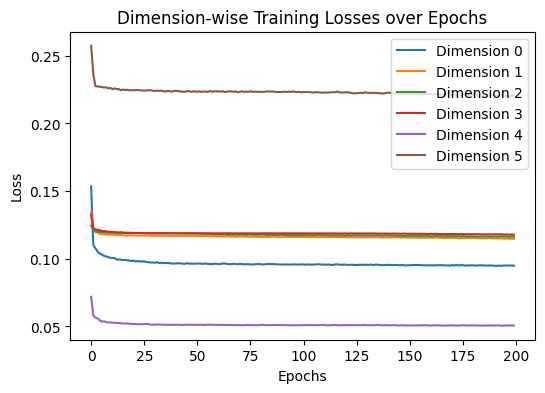

In [64]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.plot(feature_losses[f"dim_{i}"], label=f"Dimension {i}")
plt.legend()
plt.title("Dimension-wise Training Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Save the plot with a specific DPI
plt.savefig('pic/training_loss_0315.png', dpi=300)  # 300 DPI is a common high-resolution setting
plt.show()

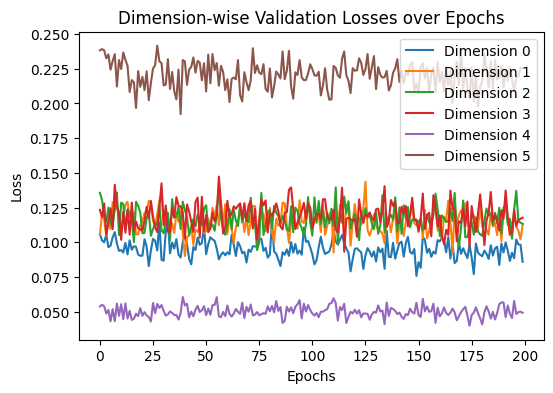

In [66]:
plt.figure(figsize=(6,4))
for i in range(6):
    plt.plot(val_feature_losses[f"dim_{i}"], label=f"Dimension {i}")
plt.legend()
plt.title("Dimension-wise Validation Losses over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# Save the plot with a specific DPI
plt.savefig('pic/val_loss_0322.png', dpi=300)  # 300 DPI is a common high-resolution setting
plt.show()